# Script to view sensitivity analysis data from light calculations

Here we plot the effect of running the RTM with and without the effect of melt ponds and other variables
on the output for PAR and UV-B


In [37]:
import os
import glob
import pandas as pd
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
from datetime import datetime
import calendar
from typing import List, Tuple, Dict
import warnings
from matplotlib import ticker, cm
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import seaborn as sns
import geopandas as gp
import regionmask
import matplotlib.pyplot as plt
plt.style.use('default')
import cartopy.crs as ccrs
import os
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from collections import namedtuple

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import geopandas as gpd
import rioxarray as rio
from shapely.geometry import mapping
from texttable import Texttable
import gcsfs
import geopandas as gpd
from CMIP6_IO import CMIP6_IO

In [38]:
def list_all_model_combinations(prefix, period, factor_names):
    io = CMIP6_IO()
    files_on_gcs = []
    counter=0
    for blob in io.bucket.list_blobs(prefix=prefix):
        if period in blob.name and "srf" not in blob.name:
            counter+=1
            files_on_gcs.append(blob.name) 
        
    # Variable names
    var_names = np.unique([file.split('/')[-1].split('_')[0] for file in files_on_gcs]).tolist()
    var_names = list(map(lambda x: x.replace("sw","sw_srf"), var_names))
 
    print(var_names)
        
    # Model names
    model_names = np.unique([file.split('/')[-1].split('_')[1] for file in files_on_gcs])
    # Member IDS
    file_names = np.unique([file.split('/')[-1].split('_')[2] for file in files_on_gcs])
    file_names = [file for file in file_names if file.startswith('r')]
    member_names = np.unique(file_names)

    s="_"
    combined_names=[]
    for var_name in var_names:
        for model_name in model_names:
            for member_name in member_names:
                combined_names.append(s.join([var_name,model_name,member_name]))

    print(f"Total number of files in bucket {counter} and unique variables {len(var_names)} and models {len(model_names)} and combined {len(combined_names)}")
    combos = namedtuple('combos', ['combined_names', 'factor_names', 'model_names'])

    return combos(np.unique(combined_names), factor_names, model_names), files_on_gcs

In [39]:
def get_LME_records():
    lme_file = "gs://actea-shared/Shapefiles/LME66/LMEs66.shp"
    return gpd.read_file(lme_file)

def convert_to_180(ds):
    return (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby('lon')

def get_data_within_LME(ds, LME):
    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
    shdf_sel = shdf[shdf["LME_NAME"] == LME]
    
   # ds = ds.rio.write_crs(4326)
    ds.rio.set_spatial_dims(y_dim="lat", x_dim="lon", inplace=True)
    ds.rio.write_crs(4326,  inplace=True)
    
    clipped = ds.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=ds.rio.crs)
    if "x" in ds.dims:
        clipped = clipped.rename({"x": "lon", "y": "lat"})
   
    return clipped

In [40]:

def fix_LME_name(LME):
    return LME.replace(" - ", "_").replace(" ", "_")

def calculate_stats(LME_data, model_var, factor):
    LME_stats={}
    stats = namedtuple('stats', ['mean', 'std', 'max'])
    for LME, (ds1, ds2) in LME_data.items():
        ds1 = ds1.mean(dim=['lat', 'lon'], skipna=True)
        ds2 = ds2.mean(dim=['lat', 'lon'], skipna=True)
        
        ds_mean = ((ds1[model_var].mean().values-ds2[model_var].mean().values)/ds2[model_var].mean().values)*100
        ds_max = ((ds1[model_var].max().values-ds2[model_var].max().values)/ds2[model_var].max().values)*100
        ds_std = ((ds1[model_var].std().values-ds2[model_var].std().values)/ds2[model_var].std().values)*100
        
        stats_for_lme = stats(ds_mean, ds_std, ds_max)
        LME_stats[LME] = stats_for_lme
        
    return LME_stats
        
def plot_timeseries(LME_data, model_var, factor):
    for LME, (ds1, ds2) in LME_data.items():
        ds1_timeseries = ds1.mean(dim=['lat', 'lon']).resample(time='ME').mean(skipna=True)
        ds2_timeseries = ds2.mean(dim=['lat', 'lon']).resample(time='ME').mean(skipna=True)
        fig,ax = plt.subplots()
        ax.plot(ds1_timeseries.time, ds1_timeseries[model_var], linewidth=0.5, label=factor)
        ax.plot(ds2_timeseries.time, ds2_timeseries[model_var],linewidth=0.5, label="osa")
        ax.legend()
        plt.show()
  
        fig,ax = plt.subplots()
        ax.plot(ds2_timeseries.time, (ds1_timeseries[model_var]-ds2_timeseries[model_var])/ds2_timeseries[model_var]*100, linewidth=0.9, label=f"{factor}-osa")
        ax.legend()
        plt.show()
    
def plot_map_of_diff(LME_data, model_var, factor):
    for LME, (ds1, ds2) in LME_data.items():
        ds1 = ds1.resample(time='1M').mean()
        ds2 = ds2.resample(time='1M').mean()
        ds1_spatial = ds1.mean(dim=['time'])
        ds2_spatial = ds2.mean(dim=['time'])

        projection=ccrs.PlateCarree(central_longitude=180)
       # fig,ax = plt.subplots()
        ((ds1_spatial[model_var] - ds2_spatial[model_var])/ds2_spatial[model_var] * 100).plot(transform=ccrs.PlateCarree(), subplot_kws={'projection': projection})
        plt.show()
        
def get_data(ds1, ds2, LMES):
    ds1.coords['lon'] = (ds1.coords['lon'] + 180) % 360 - 180
    ds2.coords['lon'] = (ds2.coords['lon'] + 180) % 360 - 180
    ds1 = ds1.sortby(ds1.lon)
    ds2 = ds2.sortby(ds2.lon)

    #clip the netcdf data to LME boundary
    ds1.rio.set_spatial_dims(x_dim = "lon", y_dim = "lat", inplace = True)
    ds1.rio.write_crs("epsg:4326", inplace = True)
    ds2.rio.set_spatial_dims(x_dim = "lon", y_dim = "lat", inplace = True)
    ds2.rio.write_crs("epsg:4326", inplace = True)

    #clip the data
    LME_data = {}
    for LME in LMES:
        ds1_clipped = get_data_within_LME(ds1, LME)
        ds2_clipped = get_data_within_LME(ds2, LME)
    
        aligned_ds1, aligned_ds2 = xr.align(ds1_clipped, ds2_clipped, join='outer')
        nan_mask_ds1 = aligned_ds1.isnull()
        nan_mask_ds2 = aligned_ds2.isnull()
        combined_nan_mask = nan_mask_ds1 | nan_mask_ds2
        filtered_ds1 = aligned_ds1.where(~combined_nan_mask, drop=True)
        filtered_ds2 = aligned_ds2.where(~combined_nan_mask, drop=True)  
        
        LME_name = fix_LME_name(LME)
        LME_data[LME_name] = (filtered_ds1, filtered_ds2)
        
    return LME_data

In [41]:
def create_lollipop_chart(df: pd.DataFrame, model_var: str, factors, LMES: List, model_stats="mean", factors_renamed: Dict = None):
    for LME in LMES:
        my_range = []
        LME_name = fix_LME_name(LME)
        
        fig, ax = plt.subplots(1, 1, figsize = (6, 6))
        counter=0
        
        # Loop through the four removed settings (each loop will have an offset for the graph, the removed setting 
        # to subset the data, and a color for the graph)
        for i, var, col in zip([-0.3, -0.2, 0.0, 0.1, 0.2, 0.3, 0.4], factors, ['tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:orange','tab:cyan','magenta']):
            
            # We exclude sea ice as the effect leads to 200% difference and skews the graph
            if var not in []: #['no_ice']:
                
                # Subset the data for only the removed variable and LME
                data_temp = df[df['factor'] == var]
                data_temp = data_temp[data_temp['LME'] == LME_name]
        
                # Create a range based on the length of data and add the offset
                my_range=range(1,len(data_temp.index)+1)
                my_range = [j + i for j in my_range]
               
                # Create horizontal plot using the hline function and the plot function
                ax.hlines(y=my_range, xmin=0, xmax=data_temp[model_stats], color = col)
                ax.plot(data_temp[model_stats], my_range, "o", color = col, label = factors_renamed[counter])
                counter+=1
                
        #add titles and axis names
        ax.set_yticks(range(1, len(data_temp['member']) + 1), data_temp['member'])
        #fig.suptitle(f"{LME_name} Effect of feature", horizontalalignment='left', x = 0.125, y = 0.93)
      #  ax.set_title('Averaged between 1979 to 1989', loc = 'left', fontsize = 10)
        ax.set_xlabel('Percent difference (%)')
      #  ax.set_ylabel('Variable')

        #add gridlines and legend
        ax.grid(linestyle = 'dotted', color = 'lightgrey', zorder = 0)
        L = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Removed Setting')

        # Show the plot
        ax.invert_yaxis()
        plt.savefig(f"Figures/Sensitivity_effects_on_{model_var}_{LME_name}_{model_stats}.png", dpi=300, bbox_inches='tight')
    
        plt.show()

In [42]:
def create_dataframe(combined_names, stats, model_var, factor, LMES, df=None):
 
    # To avoid adding an item twice we keep record of the ones added
    already_done=[]
    for combined_name in combined_names:
        model = combined_name.split("_")[1]
        for details in stats[model].items():
            factorname = details[0].split("_")[0]
            if factor=="sw_srf":
                factorname="sw_srf"
            modelname = details[0].split("_")[1]
        
            membername = details[0]
            
            if membername not in already_done:
                if df is None:
                    df = pd.DataFrame({"mean":[details[1][LMES[0]].mean], 
                                    "std":[details[1][LMES[0]].std],
                                    "max":[details[1][LMES[0]].max],
                                    "factor":[factorname], 
                                    "model":[modelname], 
                                    "member":[membername],
                                    "model_var":[model_var],
                                    "factor":[factor],
                                    "LME":[fix_LME_name(LMES[0])]})
                   
                    df_addon = pd.DataFrame({"mean":[details[1][LMES[1]].mean], 
                                                "std":[details[1][LMES[1]].std],
                                                "max":[details[1][LMES[1]].max],
                                                "factor":[factorname], 
                                                "model":[modelname],
                                                "member":[membername],
                                                "model_var":[model_var],
                                                "factor":[factor],
                                                "LME":[fix_LME_name(LMES[1])]})
                    df = pd.concat([df, df_addon], ignore_index=True)
                   
                else:
                    for LME in LMES:
                        df_addon = pd.DataFrame({"mean":[details[1][LME].mean], 
                                                "std":[details[1][LME].std],
                                                "max":[details[1][LME].max],
                                                "factor":[factorname], 
                                                "model":[modelname],
                                                "member":[membername],
                                                "model_var":[model_var],
                                                "factor":[factor],
                                                "LME":[fix_LME_name(LME)]})
                        
                        df = pd.concat([df, df_addon], ignore_index=True)
            already_done.append(membername)
       
    return df


## Process Data


In [43]:
io = CMIP6_IO()
model_vars=["osa","uvb","uvi"]
model_vars=["par"]
for model_var in model_vars:
    model_stats="mean" # mean, std, max, min

    LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas']
    scenario = "ssp245"
    lightpath = "light_sensitivity"
    prefix=f'{lightpath}/{scenario}'

    stats  = {}
    factors = ["snow_sensitivity", "no_chl", "no_wind", "no_osa", "no_meltpond"] #, "no_ice","no_clouds"]
    factors_renamed = ["Snow attenuation", "No chl effect", "No wind effect", "Constant OSA (Taylor et al. 1996)", "No meltponds"] #, 
                  #  "No seaice","no_clouds"]
    #factors = ["no_clouds"]
    #factors_renamed = ["No clouds effect"]

    period="1979-01-01-1989-01-16"
    df = None
    create_csv=False
    combos, files_on_gcs = list_all_model_combinations(prefix, period, factors)

    max_plots=1
    counter=0

    if create_csv:
        for factor in factors:
            for combined_name in combos.combined_names:
                if model_var in combined_name:
                    
                    model = combined_name.split("_")[1]
                    file1 = f"light_sensitivity/ssp245/{combined_name}_{period}_scenario_{factor}_ssp245.nc"
                    file2 = f"light_sensitivity/ssp245/{combined_name}_{period}_scenario_osa_ssp245.nc"
                
                    ds1 = io.open_dataset_on_gs(file1)
                    ds2 = io.open_dataset_on_gs(file2)
                    print(file2)
                
                    if ds1 and ds2:
                        print(file1, file2)
                        ds1=ds1.resample(time='ME', skipna=True).mean()
                        ds2=ds2.resample(time='ME', skipna=True).mean()
                    
                        LME_data = get_data(ds1, ds2, LMES)
                
                        LME_stats = calculate_stats(LME_data, model_var, factor)
                        LME_names = [fix_LME_name(LME) for LME in LMES]

                        if model not in stats:  
                            stats[model] = {}
                        if combined_name not in stats[model]:  
                            stats[model][combined_name] = {}
                        stats[model][combined_name] = LME_stats
                                        
                    #   if counter < max_plots:                
                    #       plot_timeseries(LME_data, model_var, factor)
                        #  plot_map_of_diff(LME_data, model_var, factor)
                        counter+=1
            #plot_timeseries(LME_data, model_var, factor)
            counter=0
            df = create_dataframe(combos.combined_names, stats, model_var, factor, LME_names, df)
            df.to_csv(f"csv/RTM_sensitivity_on_{model_var}.csv")

['ghi', 'osa', 'par', 'uv', 'uva', 'uvb', 'uvi']
Total number of files in bucket 896 and unique variables 7 and models 4 and combined 392


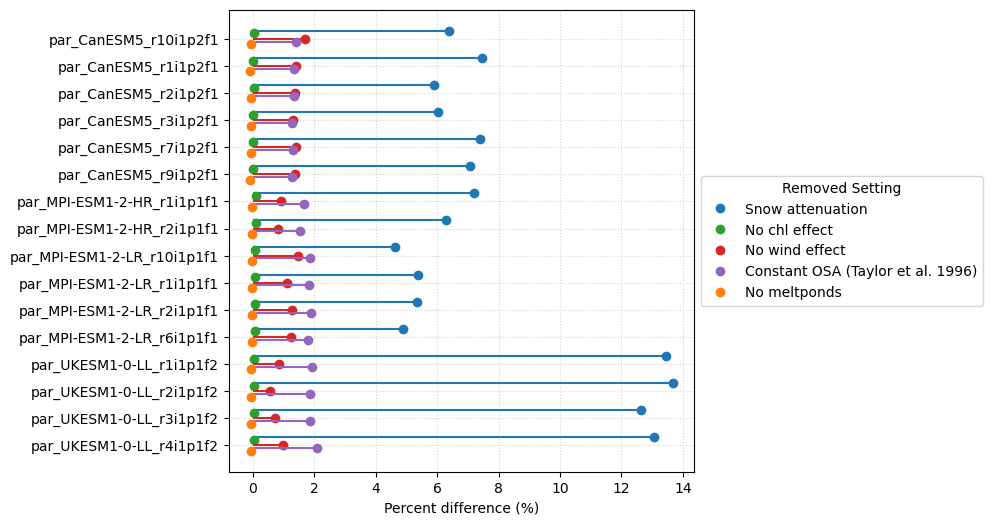

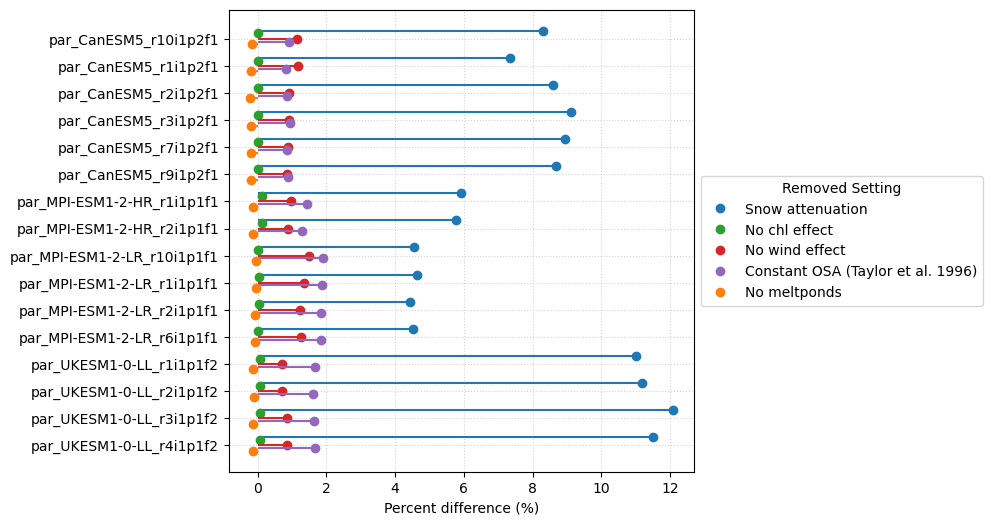

In [44]:
for model_var in model_vars:
    df = pd.read_csv(f"csv/RTM_sensitivity_on_{model_var}.csv")
    create_lollipop_chart(df, model_var, factors, LMES, model_stats, factors_renamed)

In [45]:
model_var="par"
df = pd.read_csv(f"csv/RTM_sensitivity_on_{model_var}.csv")

for LME in ["Northern_Bering_Chukchi_Seas", "Barents_Sea"]:
    print(f"\n{LME}")
    for factor in factors:
        
        data_temp = df[df['factor'] == factor]
        data_temp = data_temp[data_temp['LME'] == LME]
        plus_minus_symbol = "\u00B1"
        print(f"{data_temp[model_stats].mean():3.4f} {plus_minus_symbol} {data_temp[model_stats].std():3.2f} % {factor} ")


Northern_Bering_Chukchi_Seas
7.9138 ± 2.69 % snow_sensitivity 
0.0458 ± 0.04 % no_chl 
1.0116 ± 0.23 % no_wind 
1.3742 ± 0.43 % no_osa 
-0.1358 ± 0.06 % no_meltpond 

Barents_Sea
7.9215 ± 3.26 % snow_sensitivity 
0.0428 ± 0.02 % no_chl 
1.1578 ± 0.32 % no_wind 
1.6335 ± 0.28 % no_osa 
-0.0538 ± 0.02 % no_meltpond 
